In [1]:
from fst.io import read
import numpy as np
import skimage as sk
import scipy.ndimage as ndi
import napari 
import dask.array as da
from distributed import Client
from fst.distributed import get_jobqueue_cluster
%gui qt

/groups/scicompsoft/home/bennettd/miniconda3/lib/python3.7/site-packages/napari/__init__.py:27: UserWarning: 
    napari was tested with QT library `>=5.12.3`.
    The version installed is 5.9.7. Please report any issues with this
    specific QT version at https://github.com/Napari/napari/issues.
    
  warn(message=warn_message)


In [2]:
client = Client(get_jobqueue_cluster())
jq = client.cluster
client

Client Scheduler: tcp://10.36.111.14:38507 Dashboard: http://10.36.111.14:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
ds = 16
data = da.from_array(read('/groups/cosem/cosem/data/LoadID365_ROI4_8x8x8nm/LoadID365_ROI4_8x8x8nm.n5/volumes/proc'))
data

,Array,Chunk
Bytes,136.06 GB,33.55 MB
Shape,"(6803, 1000, 10000)","(256, 256, 256)"
Count,4321 Tasks,4320 Chunks
Type,uint16,numpy.ndarray


In [4]:
loc = data[::8,::8,::8]
loc

,Array,Chunk
Bytes,265.94 MB,65.54 kB
Shape,"(851, 125, 1250)","(32, 32, 32)"
Count,8641 Tasks,4320 Chunks
Type,uint16,numpy.ndarray


In [5]:
jq.start_workers(30)
loc = loc.compute()
jq.stop_all_jobs()

In [6]:
from dask import delayed

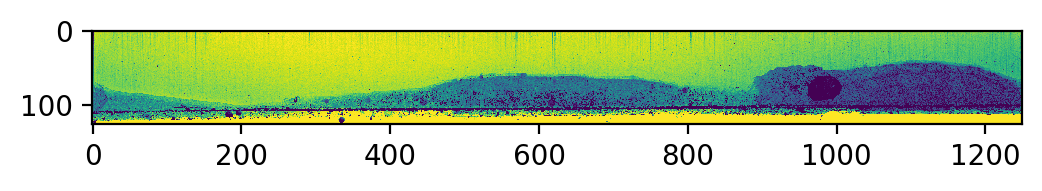

In [17]:
fig, axs = plt.subplots(dpi=200)
plt.imshow(loc.min(0), clim=(40000,50000))

In [290]:
import scipy.stats as st

In [390]:
def stdf(im, sigma1=1, sigma2=1):
    from scipy.ndimage import gaussian_filter
    return gaussian_filter((im - gaussian_filter(im, sigma=sigma1)) ** 2, sigma=sigma2) ** .5

In [391]:
flocs = {}
sigmas = [(1,4),(4,4),(8,4)]
for sig1, sig2 in sigmas:
    flocs[sig1] = stdf(loc[:,10:-10,10:-10].astype('float32'), sigma1=sig1, sigma2=sig2)
    

In [405]:
from skimage.morphology import ball, disk
import scipy.ndimage.morphology as morph 

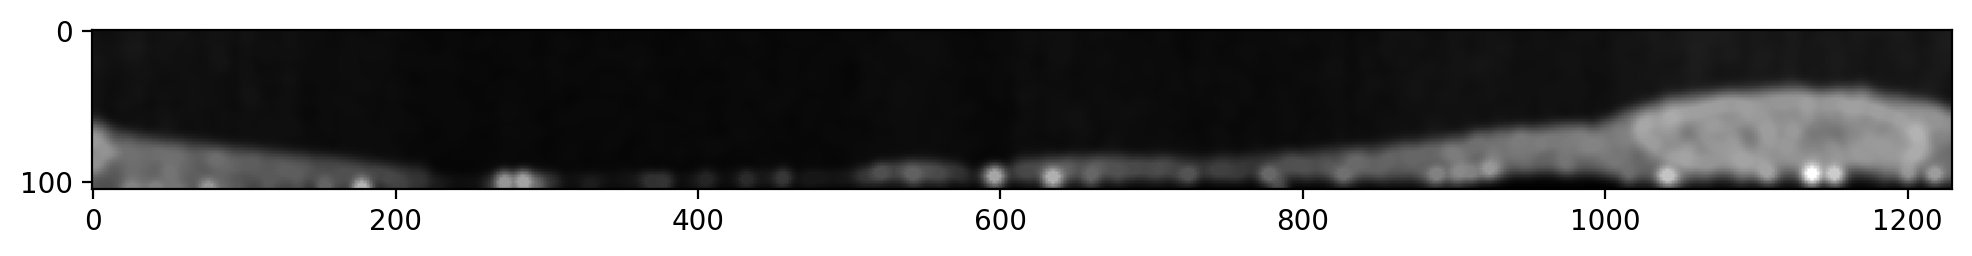

In [428]:
fig, axs = plt.subplots(dpi=200, figsize=(12,12))
axs.imshow(morph.grey_opening(flocs[1].astype('int')[0], footprint=disk(3)), cmap='gray')

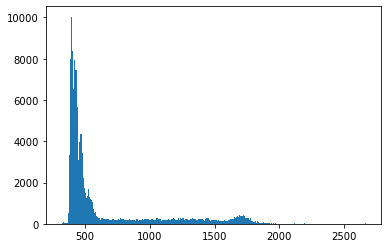

In [427]:
plt.hist(morph.grey_opening(flocs[1].astype('int')[0], footprint=disk(3)).ravel(),300);

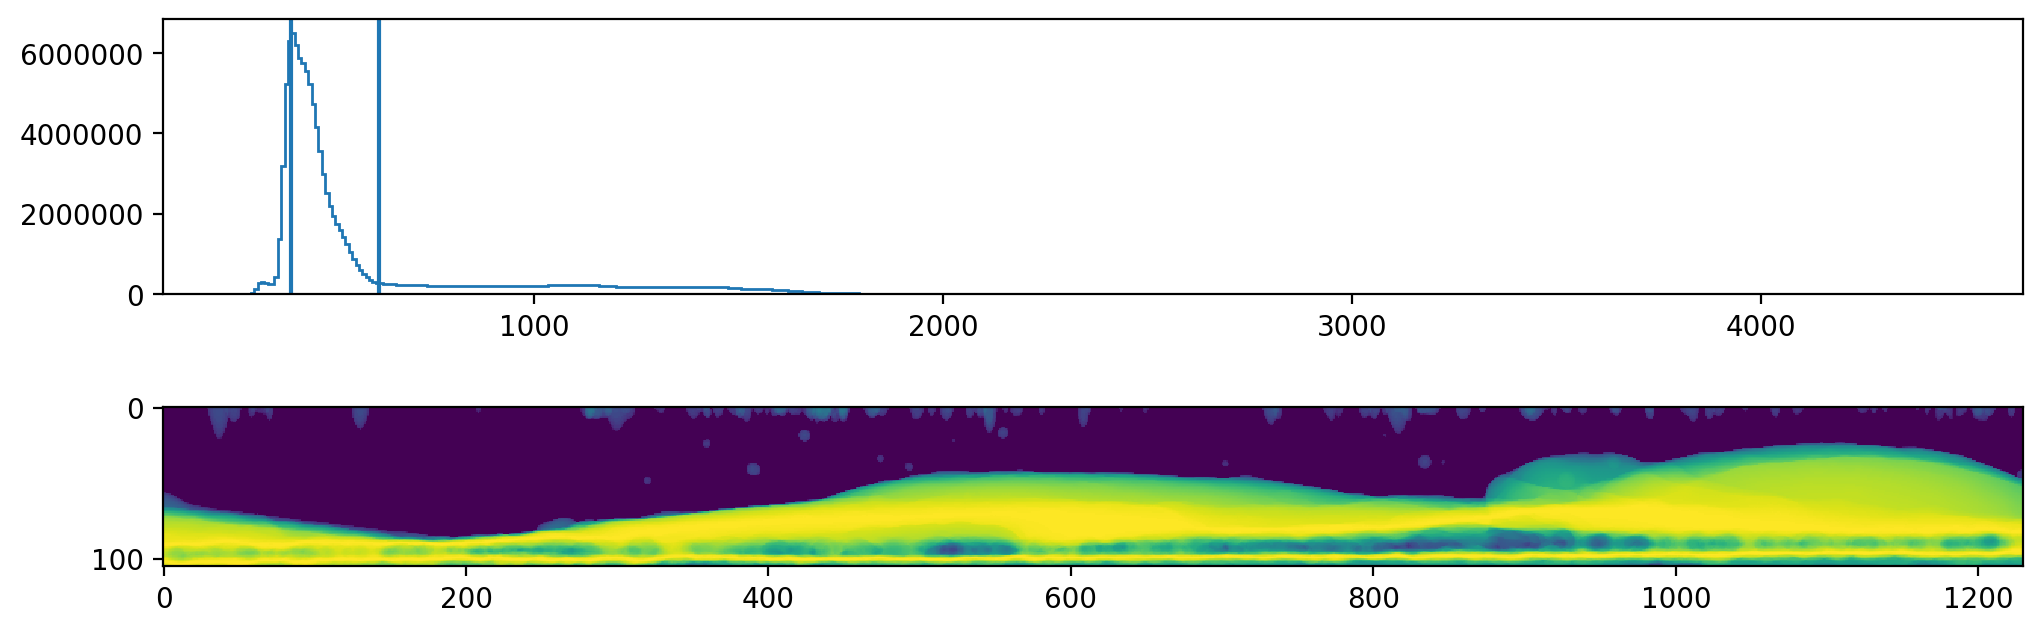

In [389]:
fig, axs = plt.subplots(dpi=200, figsize=(12,4), nrows=2)

counts, bins, patches = axs[0].hist(flocs[1].ravel(), 500, histtype='step');
mode = bins[np.argmax(counts)]
thr = mode + 2 * (mode - bins[0])
axs[0].axvline(mode)
axs[0].axvline(thr)
axs[1].imshow((flocs[1] > thr).std(0))

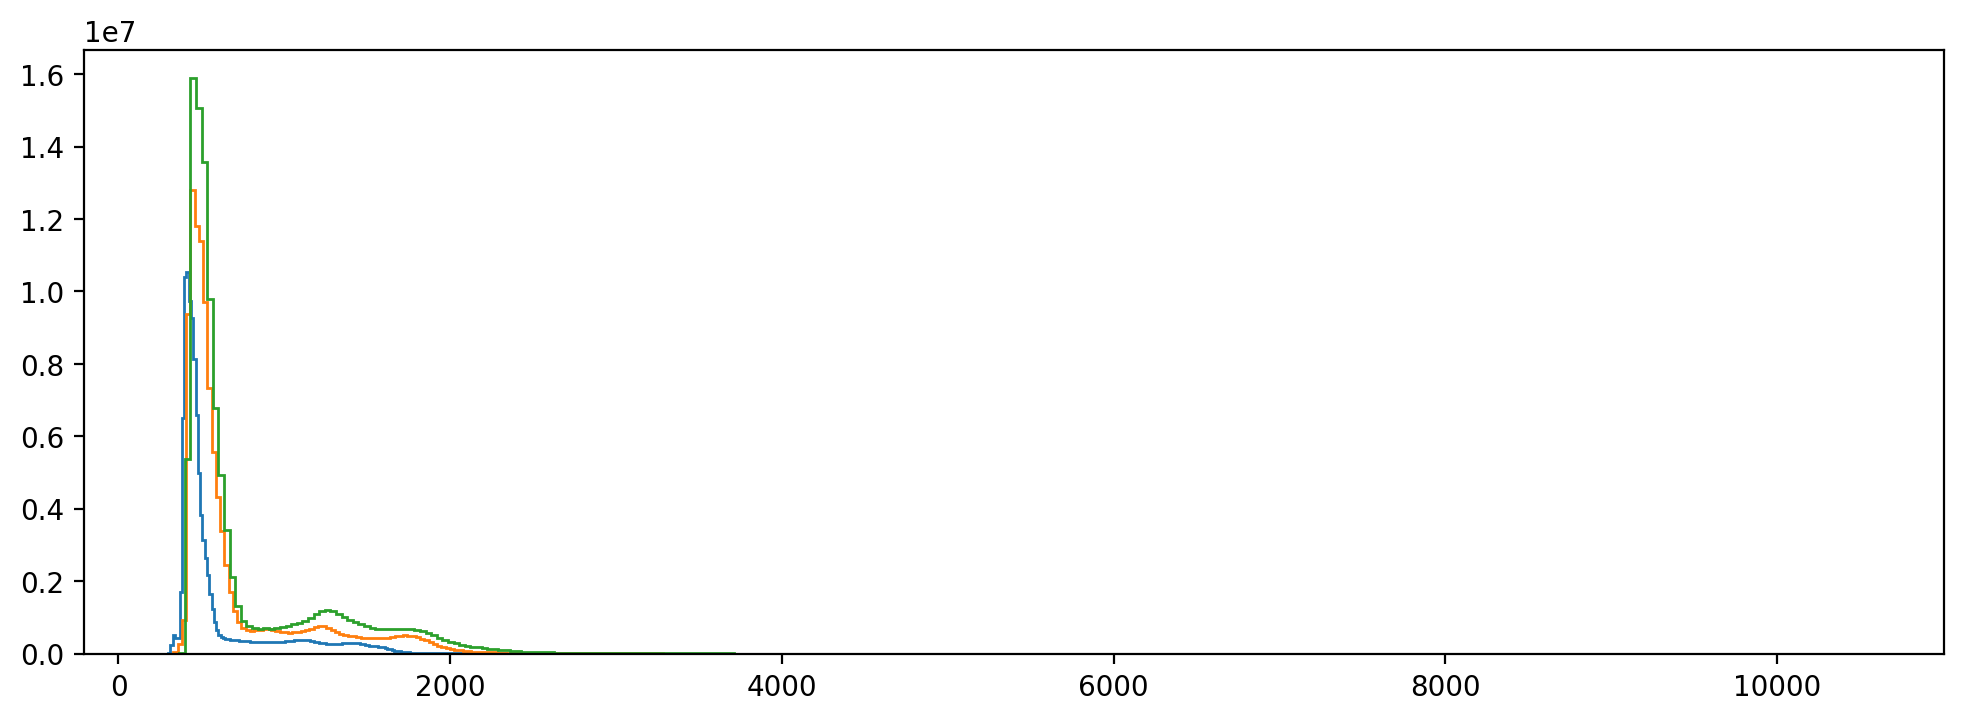

In [374]:
fig, axs = plt.subplots(dpi=200, figsize=(12,4))
from scipy.stats import zscore
axs.hist(flocs[1].ravel(), 300, histtype='step');
axs.hist(flocs[4].ravel(), 300, histtype='step');
axs.hist(flocs[8].ravel(), 300, histtype='step');
#axs.semilogx()
#plt.hist(flocs[8].ravel(),300);

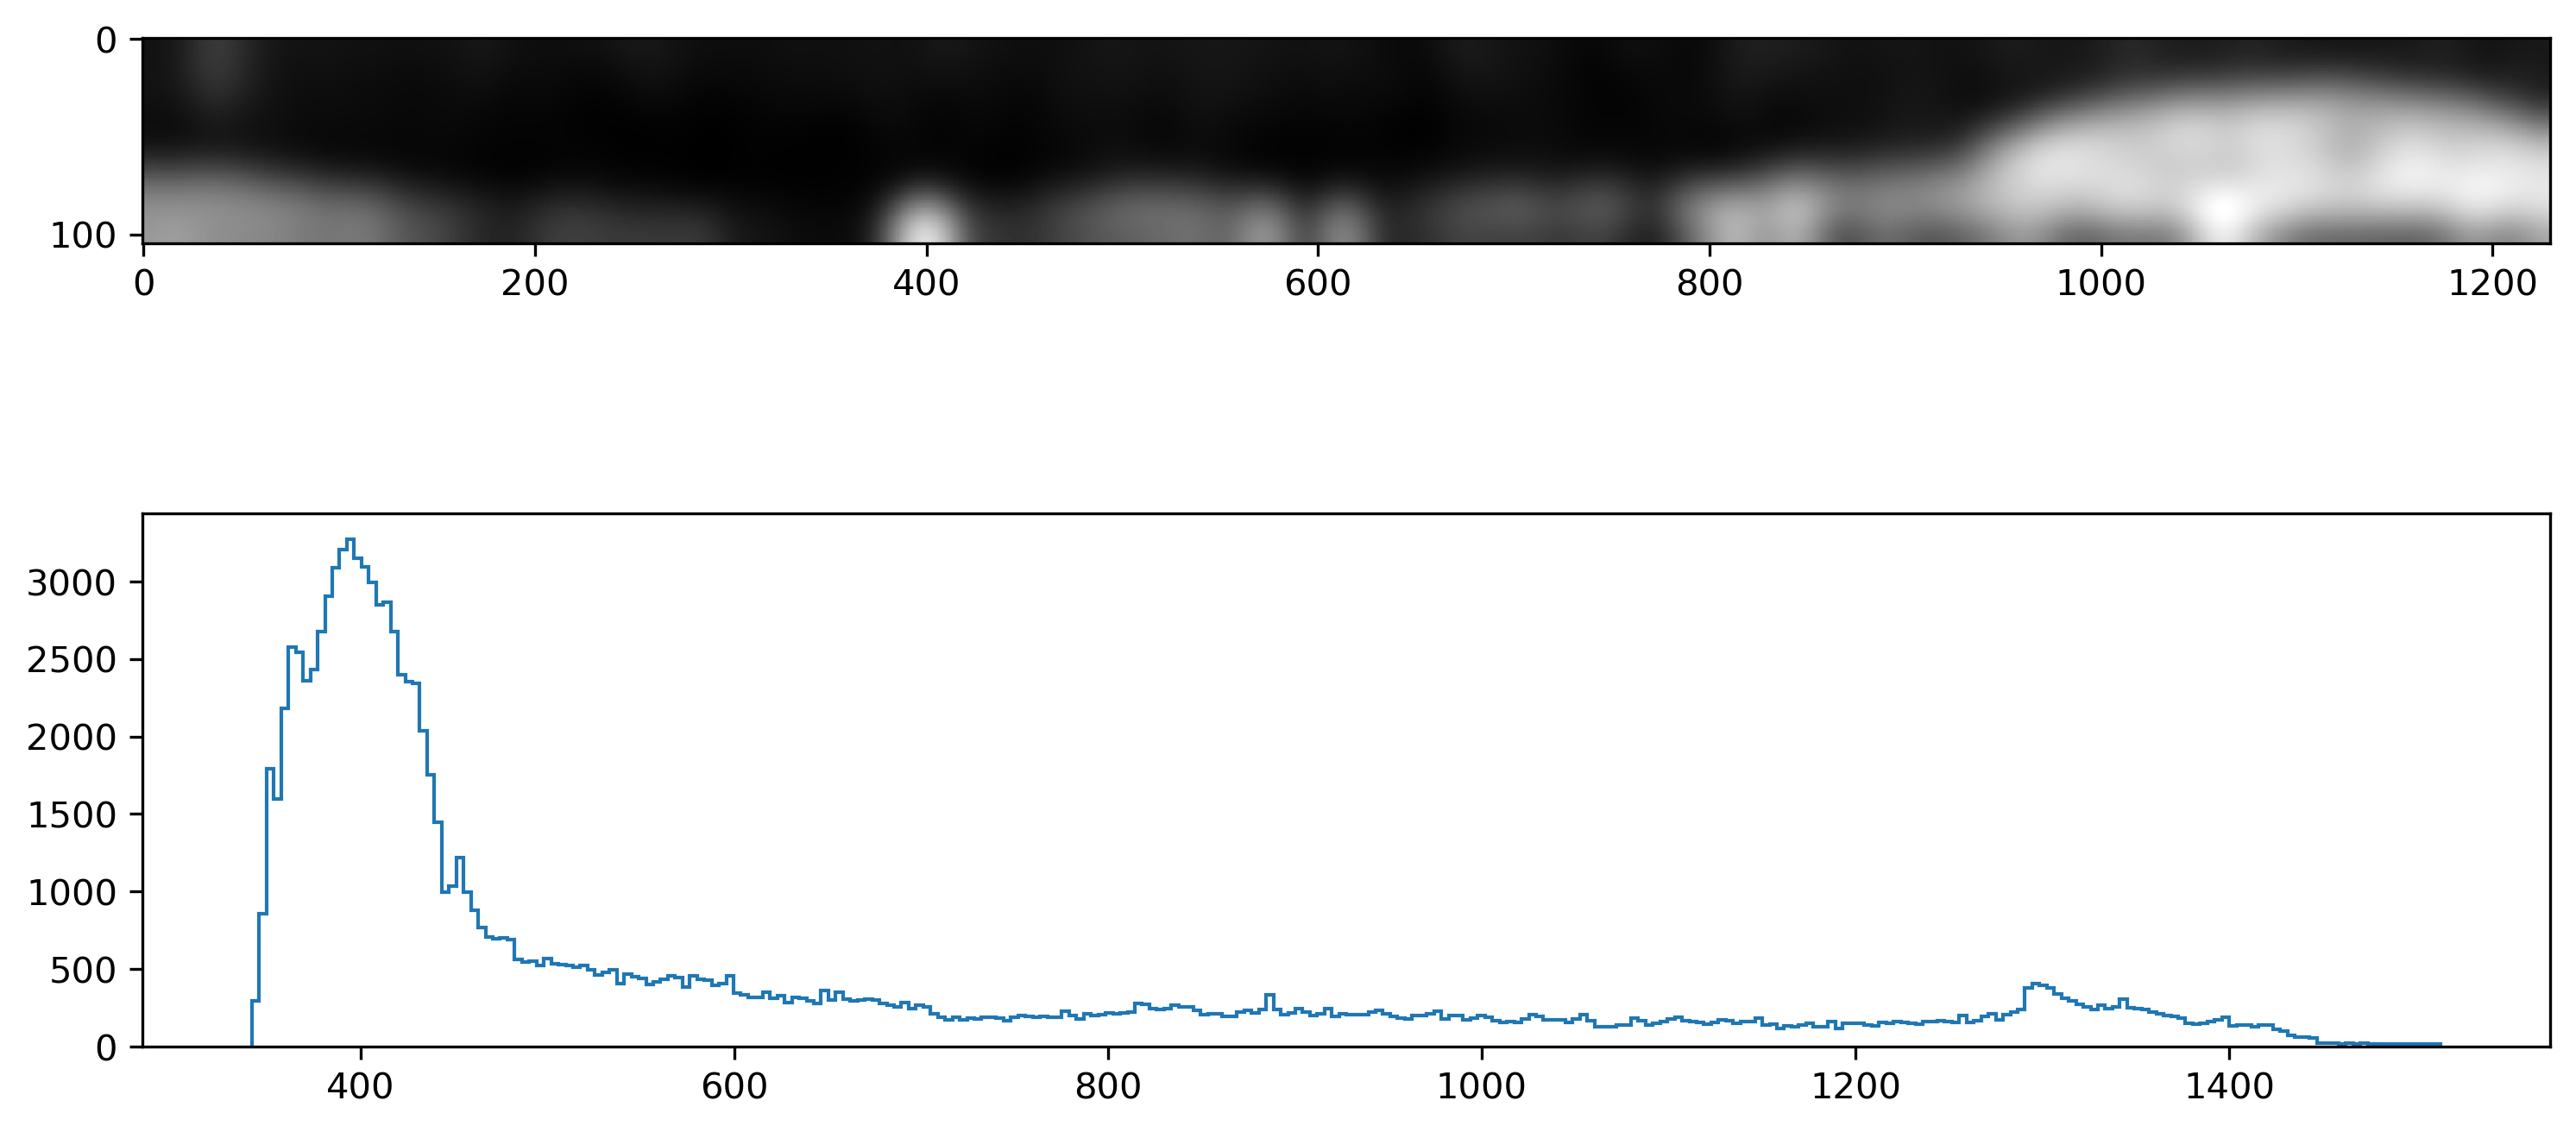

In [354]:
dog = lambda v, sigma: v - ndi.gaussian_filter(v, sigma)
fig, axs = plt.subplots(dpi=300, figsize=(12,6), nrows=2)
tmp = ndi.gaussian_filter(dog(loc[100,10:-10,10:-10].astype('float32'), sigma=1) ** 2, sigma=12) ** .5
axs[0].imshow(tmp, cmap='gray')
axs[1].hist(tmp.ravel(),300, histtype='step');

In [124]:
napari.view(floc=floc, loc=loc)